In [2]:
# default_exp basic_train
%load_ext autoreload
%autoreload 2

In [3]:
# hide
from nbdev.showdoc import *
from nbdev.imports import *
from nbdev.export2html import *
if not os.environ.get("IN_TEST", None):
    assert IN_NOTEBOOK
    assert not IN_COLAB
    assert IN_IPYTHON

# Basic Train

> Contains basic Learners and Agents

In [4]:
# export
from fastai.basic_data import *
from fastai.basic_train import *
from fastai.torch_core import *
from fastai.layers import *
from fastrl.data_block import *
from fastrl.basic_agents import *
from dataclasses import asdict
import logging
import gym

In [5]:
# hide
import gym
import sys

logging.basicConfig(format='[%(asctime)s] p%(process)s line:%(lineno)d %(levelname)s - %(message)s',
                    datefmt='%m-%d %H:%M:%S')
logging.getLogger('fastrl.data_block').setLevel('CRITICAL')
_logger=logging.getLogger(__name__)
_logger.setLevel('INFO')

## Learners

There is an important difference between `Learner`'s, `nn.Module`'s, and `Agent`'s. 

`Learners`:
- Contain `Agent`'s, `DataBunch`'s, `Callback`'s, and auxiliary objects such as `Experience`. 
- Function as orchestrators which handle the entire training cycle.
- Are not as portable / simple since they hold many different objects, some of which are not needed for simple execution.

`nn.Module`:
- Contain only `pytorch` related code.
- Function as the brain of any of these agents and are the objects to be optimized.
- Are highly portable, however for runtime usage are too "dumb" or simple to be practical. If by themselves, extra code needs to wrap them to handle environments.

`Agent` (`agent_core`):
- Ref `basic_agents`

In [6]:
# export
class FloatifyCallback(LearnerCallback):
    def on_batch_begin(self,last_input,**kwargs):
        return {'last_input':[o.float() for o in last_input]}
    
class FakeRunCallback(LearnerCallback):
    def on_backward_begin(self,*args,**kwargs): return {'skip_bwd':True,'skip_validate':True}
    

@dataclass
class LatentLossBuffer(object):
    "Most RL agents have complex / intensive loss functions that need to be handled by the trainers. This primarily serves as a compat layer with fastai."
    loss:float=0.5
    
    def __call__(self,xb,yb):return tensor(self.loss)

In [7]:
Learner??

Init signature:
Learner(
    data: fastai.basic_data.DataBunch,
    model: torch.nn.modules.module.Module,
    opt_func: Callable = functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)),
    loss_func: Callable = None,
    metrics: Collection[Callable] = None,
    true_wd: bool = True,
    bn_wd: bool = True,
    wd: Union[float, Collection[float]] = 0.01,
    train_bn: bool = True,
    path: str = None,
    model_dir: Union[pathlib.Path, str] = 'models',
    callback_fns: Collection[Callable] = None,
    callbacks: Collection[fastai.callback.Callback] = <factory>,
    layer_groups: Collection[torch.nn.modules.module.Module] = None,
    add_time: bool = True,
    silent: bool = None,
) -> None
Source:        
class Learner():
    "Trainer for `model` using `data` to minimize `loss_func` with optimizer `opt_func`."
    data:DataBunch
    model:nn.Module
    opt_func:Callable=AdamW
    loss_func:Callable=None
    metrics:Collection[Callable]=None
    true_wd:bool=True
   

In [8]:
# export
@dataclass
class AgentLearner(Learner):
    data:DataBunch
    model:nn.Module
    agent:BaseAgent=BaseAgent()
    training:bool=False
        
    def __post_init__(self):
        self.callback_fns=listify(self.callback_fns)+listify(self.data.callback_fns)+listify(FloatifyCallback)
        if self.loss_func is None:self.loss_func=LatentLossBuffer()
        super(AgentLearner,self).__post_init__()
        self.data.learner=self
    
    def predict(self,s):
        return self.agent(s,None)

In [9]:
data=ExperienceSourceDataBunch.from_env('CartPole-v1',display=False,firstlast=True,add_valid=False)
model=nn.Sequential(nn.Linear(4,5),nn.ReLU(),nn.Linear(5,2))
agent=DQNAgent(model=model)
learn=AgentLearner(data,model,agent=agent,callback_fns=[FakeRunCallback])
learn.fit(10,lr=0.01,wd=1)

epoch,train_loss,valid_loss,time
0,0.500000,#na#,00:00
1,0.500000,#na#,00:00
2,0.500000,#na#,00:00
3,0.500000,#na#,00:00
4,0.500000,#na#,00:00
5,0.500000,#na#,00:00
6,0.500000,#na#,00:00
7,0.500000,#na#,00:00
8,0.500000,#na#,00:00
9,0.500000,#na#,00:00


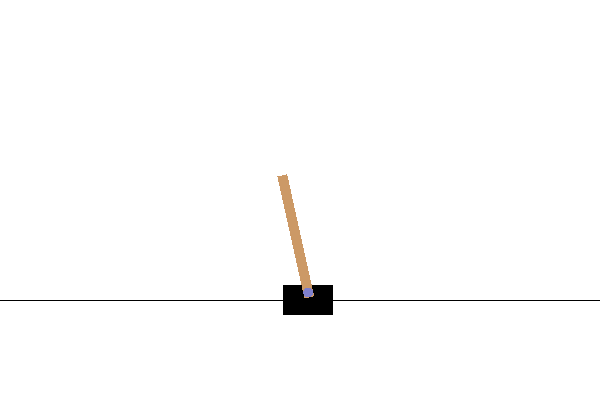

In [10]:
data=ExperienceSourceDataBunch.from_env('CartPole-v1',n_envs=5,display=True,firstlast=False,add_valid=False)
model=nn.Sequential(nn.Linear(4,5),nn.ReLU(),nn.Linear(5,2))
agent=DQNAgent(model=model)
learn=AgentLearner(data,model,agent=agent,callback_fns=[FakeRunCallback])
learn.fit(10,lr=0.01,wd=1)

In [11]:
data=AsyncExperienceSourceDataBunch.from_env('CartPole-v1',display=False,firstlast=True,add_valid=False)
model=nn.Sequential(nn.Linear(4,5),nn.ReLU(),nn.Linear(5,2))
agent=DQNAgent(model=model)
learn=AgentLearner(data,model,agent=agent,callback_fns=[FakeRunCallback])
setattr(learn,'fitter',dqn_fitter)
learn.fit(10,lr=0.01,wd=1)

TypeError: from_env() got an unexpected keyword argument 'display'

In [ ]:
data=AsyncExperienceSourceDataBunch.from_env('CartPole-v1',data_exp=False,display=False,firstlast=True,add_valid=False)
model=nn.Sequential(nn.Linear(4,5),nn.ReLU(),nn.Linear(5,2))
agent=DQNAgent(model=model)
learn=AgentLearner(data,model,agent=agent,callback_fns=[FakeRunCallback])
setattr(learn,'fitter',dqn_grad_fitter)
learn.fit(10,lr=0.01,wd=1)

In [ ]:
# hide
from nbdev.export import *
notebook2script()
notebook2html(n_workers=0)